# Pipeline for Simulating GRNS on Sergio & Packing into Anndata object

First, create the files 

Import the necessary modules

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from pyslingshot import Slingshot #for simulating pseudotimes
import numpy as np
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('../SERGIO'))
from SERGIO.sergio import sergio

/Users/JenChen/Desktop/otvelo/researchy/lib/python3.9/site-packages/pyslingshot/slingshot.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Simulate the GRN and save the splicing data to files

In [2]:
df = pd.read_csv('data/input/artificial/perturbed_matrix.tab', sep='\t', header=None, index_col=None)
bMat = df.values

#rows and cols correspond to genes and cells (just verify)
# 100 x (6 x 300 )
#  100 genes, 6 cell types, 6 bins of 300 cells per cell type
sim = sergio(number_genes=12, number_bins = 5, number_sc = 100, noise_params = 0.2, decays=0.8, sampling_state = 1, noise_params_splice = 0.07, noise_type='dpd', dynamics=True, bifurcation_matrix= bMat)
sim.build_graph(input_file_taregts ='data/input/artificial/genes.txt', input_file_regs='data/input/artificial/regulators.txt', shared_coop_state=2)
sim.simulate_dynamics()
# final ct matrix is the sum of U and S
#spliced matrix, unspliced, sum of both, pseudotime (probs just a vector bc each element in pseudotime is 1d scalar for 1 cell)
exprU, exprS = sim.getExpressions_dynamics()
exprU_clean = np.concatenate(exprU, axis = 1)
print(exprU_clean)
print(exprU_clean.shape)

exprS_clean = np.concatenate(exprS, axis = 1)
print(f"exprU_clean shape: {exprU_clean.shape}")
print(f"exprS_clean shape: {exprS_clean.shape}")

# Print the number of columns for each row
for i, row in enumerate(exprU_clean):
    print(f"Row {i} of exprU_clean has {len(row)} columns")

for i, row in enumerate(exprS_clean):
    print(f"Row {i} of exprS_clean has {len(row)} columns")

# Optionally save to text files
np.savetxt('exprU_clean.txt', exprU_clean, delimiter=' ', fmt='%f')
np.savetxt('exprS_clean.txt', exprS_clean, delimiter=' ', fmt='%f')


bindict
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


KeyError: 12

# Compute pseudotimes

First create the txt file from csv to find the pseudotimes

In [4]:
# import os

# def csv_to_txt(input_csv, output_folder="data/output"):
#     os.makedirs(output_folder, exist_ok=True)
#     output_txt = os.path.join(output_folder, os.path.basename(input_csv).replace(".csv", ".txt"))

#     with open(input_csv, 'r') as csv_file, open(output_txt, 'w') as txt_file:
#         for line in csv_file:
#             txt_file.write(line.replace(',', ' '))

#     print(f"Saved to {output_txt}")

# # Example usage in Jupyter Notebook
# input_csv = "--"  # Change this as needed
# csv_to_txt(input_csv)

#questions for wenjun: 
#what is the meaning of all of these instances of simulated csvs? are they all for the same grn and am i supposed to simulate all of them?
#for some reason when I transform the csv to txt, it's missing a single column header due to the nature of the data  
#help me figure out wt is going on w sergio


In [5]:
# data = np.loadtxt( "data_linear.txt" )

#data = np.load("data_bifurcate.npy")
def analyze_txt(input_txt):
    with open(input_txt, 'r') as txt_file:
        expected_columns = None
        for i, line in enumerate(txt_file):
            columns = line.strip().split()  # Split line into columns based on spaces
            num_columns = len(columns)
            
            if expected_columns is None:
                expected_columns = num_columns  # Set initial expected columns
            
            if num_columns != expected_columns:
                print(f"Column mismatch at row {i}: expected {expected_columns}, found {num_columns}")
            
            print(f"Row {i}: {num_columns} columns")  # Print column count for each row

# Example usage
input_txt = 'exprS_clean.txt'  # Replace with your actual TXT file path
analyze_txt(input_txt)

data = np.loadtxt( "exprS_clean.txt" )


Row 0: 300 columns
Row 1: 300 columns
Row 2: 300 columns
Row 3: 300 columns
Row 4: 300 columns
Row 5: 300 columns
Row 6: 300 columns
Row 7: 300 columns
Row 8: 300 columns
Row 9: 300 columns
Row 10: 300 columns
Row 11: 300 columns
Row 12: 300 columns
Row 13: 300 columns
Row 14: 300 columns
Row 15: 300 columns
Row 16: 300 columns
Row 17: 300 columns
Row 18: 300 columns
Row 19: 300 columns
Row 20: 300 columns
Row 21: 300 columns
Row 22: 300 columns
Row 23: 300 columns
Row 24: 300 columns
Row 25: 300 columns
Row 26: 300 columns
Row 27: 300 columns
Row 28: 300 columns
Row 29: 300 columns
Row 30: 300 columns
Row 31: 300 columns
Row 32: 300 columns
Row 33: 300 columns
Row 34: 300 columns
Row 35: 300 columns
Row 36: 300 columns
Row 37: 300 columns
Row 38: 300 columns
Row 39: 300 columns
Row 40: 300 columns
Row 41: 300 columns
Row 42: 300 columns
Row 43: 300 columns
Row 44: 300 columns
Row 45: 300 columns
Row 46: 300 columns
Row 47: 300 columns
Row 48: 300 columns
Row 49: 300 columns
Row 50: 30

In [6]:
data.shape

(100, 300)

/tmp/ipykernel_2488676/369344071.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


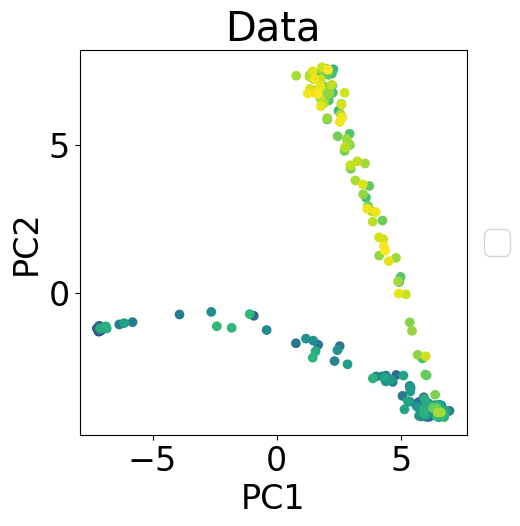

In [7]:
plt.rcParams["figure.figsize"] = (5,5)
        # PCAs:
from sklearn.decomposition import PCA
plt.rcParams["font.size"] = 24
pca = PCA()
Xt_all = pca.fit_transform(np.log2(data.T+1) ) 
plt.scatter(Xt_all[:,0],Xt_all[:,1], c=range(Xt_all.shape[0]) )
#         for j in range(Nt):
#             idx = range(num_cells_per_time*j, num_cells_per_time*(j+1))
#             plt.plot(Xt_all[idx,0],Xt_all[idx,1],'o-')
       
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
plt.show()

In [8]:
Xt_all.shape

(300, 100)

In [9]:
# from sklearn.cluster import KMeans
from anndata import AnnData
# num_clusters = 9  # Set the number of clusters you want for KMeans

# # Apply KMeans clustering
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# cluster_labels = kmeans.fit_predict(Xt_all)  # Using PCA components for clustering
cluster_labels = np.zeros( (300) )
cluster_labels[0:100] = 0
cluster_labels[100:200] = 1
cluster_labels[200:300] = 2
cluster_labels=np.int8(cluster_labels)

In [10]:
cluster_labels[0]

0

Create anndata obj

In [11]:
num_cells = data.shape[1]
num_genes = data.shape[0]
ad = AnnData(data.T)
ad.obsm["X_umap"] = Xt_all[:,0:2]
ad.obs["celltype"] = cluster_labels

In [12]:
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], d

/users/jchen397/.local/lib/python3.9/site-packages/pyslingshot/util.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isint(cluster_labels[0]):


Lineages: [Lineage[0, 1, 2]]


  0%|          | 0/1 [00:00<?, ?it/s]/users/jchen397/.local/lib/python3.9/site-packages/pyslingshot/slingshot.py:333: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
/users/jchen397/.local/lib/python3.9/site-packages/pyslingshot/slingshot.py:429: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.debug_axes[1, 0].legend()
100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


Reversing from leaf to root


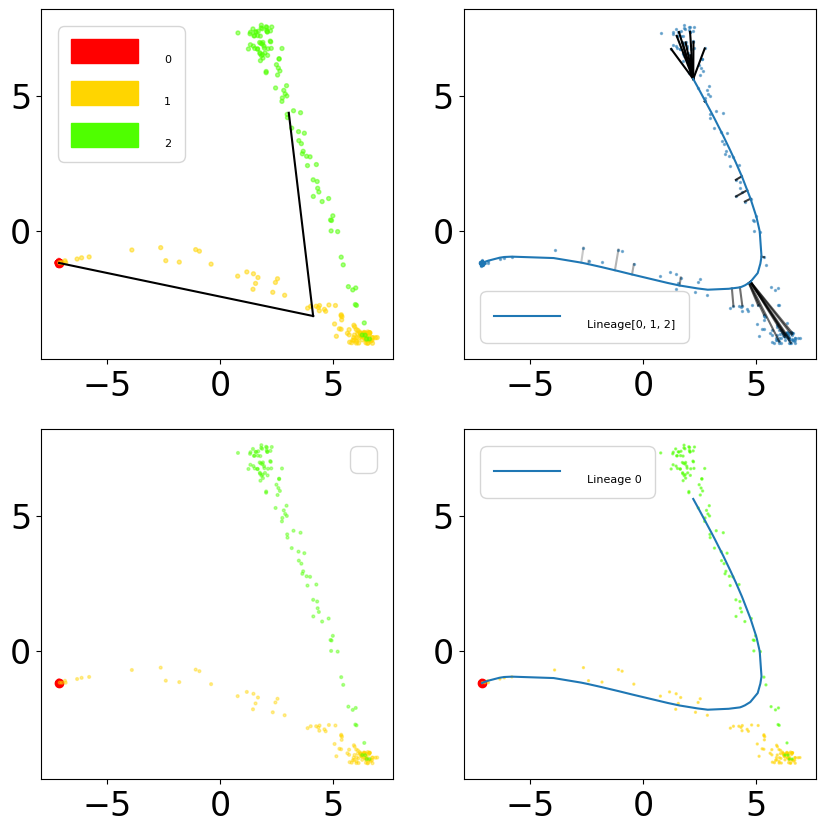

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)

slingshot = Slingshot(ad, celltype_key="celltype", obsm_key="X_umap", start_node=0, debug_level='verbose')


slingshot.fit(num_epochs=1, debug_axes=axes)

# Adjust legend size
for ax in axes.flatten():
    legend = ax.get_legend()
    if legend:
        legend.set_title(legend.get_title().get_text(), prop={'size': 10})  # Reduce legend title size
        for text in legend.get_texts():
            text.set_fontsize(8)  # Reduce legend item text size


In [14]:
pseudotime = slingshot.unified_pseudotime
ad.obs["pseudotime"] = slingshot.unified_pseudotime

print(type(slingshot.unified_pseudotime))  # Check the object type
print(slingshot.unified_pseudotime.shape)  # Check its dimensions
print(slingshot.unified_pseudotime[:5])    # Print first few values


<class 'numpy.ndarray'>
(300,)
[0.         0.0451549  0.         0.03717849 0.00543618]


Add splicing data to anndata object also

In [15]:
spliced_data = np.loadtxt("exprS_clean.txt") #spliced RNA
unspliced_data = np.loadtxt("exprU_clean.txt") #unspliced RNA

# Ensure the shape matches adata.X (genes x cells)
print(spliced_data.shape)  # Should be (num_genes, num_cells)
print(unspliced_data.shape)  # Should be (num_genes, num_cells)
print(ad.layers.keys())
# Transpose if necessary (AnnData assumes cells x genes)
if spliced_data.shape[1] == ad.n_obs and spliced_data.shape[0] == ad.n_vars:
    ad.layers["spliced"] = spliced_data.T  # Ensure it aligns with AnnData structure
    print('done w spliced')
else:
    raise ValueError("Shape mismatch! Check if genes and cells are correctly aligned.")

if unspliced_data.shape[1] == ad.n_obs and unspliced_data.shape[0] == ad.n_vars:
    ad.layers["unspliced"] = unspliced_data.T  # Ensure it aligns with AnnData structure
    print('done w unspliced')
else:
    raise ValueError("Shape mismatch! Check if genes and cells are correctly aligned.")

# Print splicing data info
print("spliced data shape:", ad.layers["spliced"].shape)
print("spliced data (first 5 genes, first 5 cells):\n", ad.layers["spliced"][:5, :5])
print("unspliced data shape:", ad.layers["unspliced"].shape)
print("unspliced data (first 5 genes, first 5 cells):\n", ad.layers["unspliced"][:5, :5])

# Print pseudotime data info
print("Pseudotime data shape:", ad.obs["pseudotime"].shape)
print("Pseudotime values (first 10 cells):\n", ad.obs["pseudotime"].head(10))
print(ad.layers.keys())
ad.write("custom_ad.h5ad")


(100, 300)
(100, 300)
KeysView(Layers with keys: )
done w spliced
done w unspliced
spliced data shape: (300, 100)
spliced data (first 5 genes, first 5 cells):
 [[15.775929  1.051437 23.359707  5.660807 13.104901]
 [16.248326  0.99772  20.82355   5.687755 12.766884]
 [16.209488  0.962001 20.902222  5.365915 13.34694 ]
 [16.25407   1.022496 20.78904   5.656117 12.71913 ]
 [16.0823    0.979495 20.086446  5.457833 13.116843]]
unspliced data shape: (300, 100)
unspliced data (first 5 genes, first 5 cells):
 [[4.12808  0.227439 5.931661 1.417335 2.577011]
 [3.686665 0.239983 5.162286 1.115017 3.162964]
 [4.567217 0.152688 4.846217 1.803249 3.368647]
 [3.806345 0.222866 5.33268  1.19104  3.094573]
 [3.670066 0.289984 5.052031 1.191726 3.158051]]
Pseudotime data shape: (300,)
Pseudotime values (first 10 cells):
 0    0.000000
1    0.045155
2    0.000000
3    0.037178
4    0.005436
5    0.052390
6    0.022176
7    0.000000
8    0.000000
9    0.033256
Name: pseudotime, dtype: float64
KeysView(Lay

/tmp/ipykernel_2488676/332775482.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


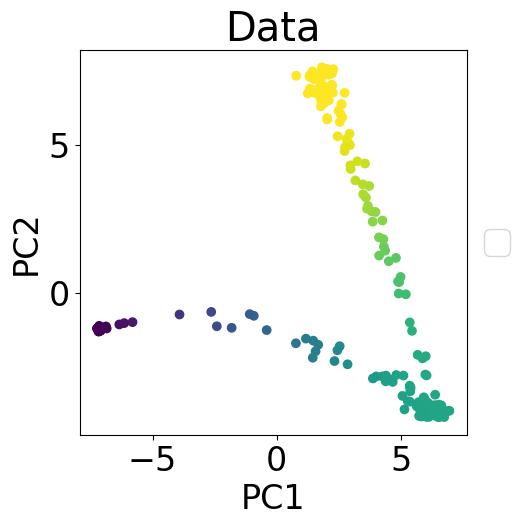

In [16]:
plt.rcParams["figure.figsize"] = (5,5)
        # PCAs:
from sklearn.decomposition import PCA
plt.rcParams["font.size"] = 24
pca = PCA()
Xt_all = pca.fit_transform(np.log2(data.T+1) ) 
plt.scatter(Xt_all[:,0],Xt_all[:,1], c=pseudotime )
#         for j in range(Nt):
#             idx = range(num_cells_per_time*j, num_cells_per_time*(j+1))
#             plt.plot(Xt_all[idx,0],Xt_all[idx,1],'o-')
#how to keep track of which cell is corr to which branch
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
plt.show()

In [ ]:
scv.pp.filter_and_normalize(ad, min_shared_counts=20, n_top_genes=2000)
ad

scv.tl.velocity_pseudotime(adata)
plt.hist( adata.obs['velocity_pseudotime'] )

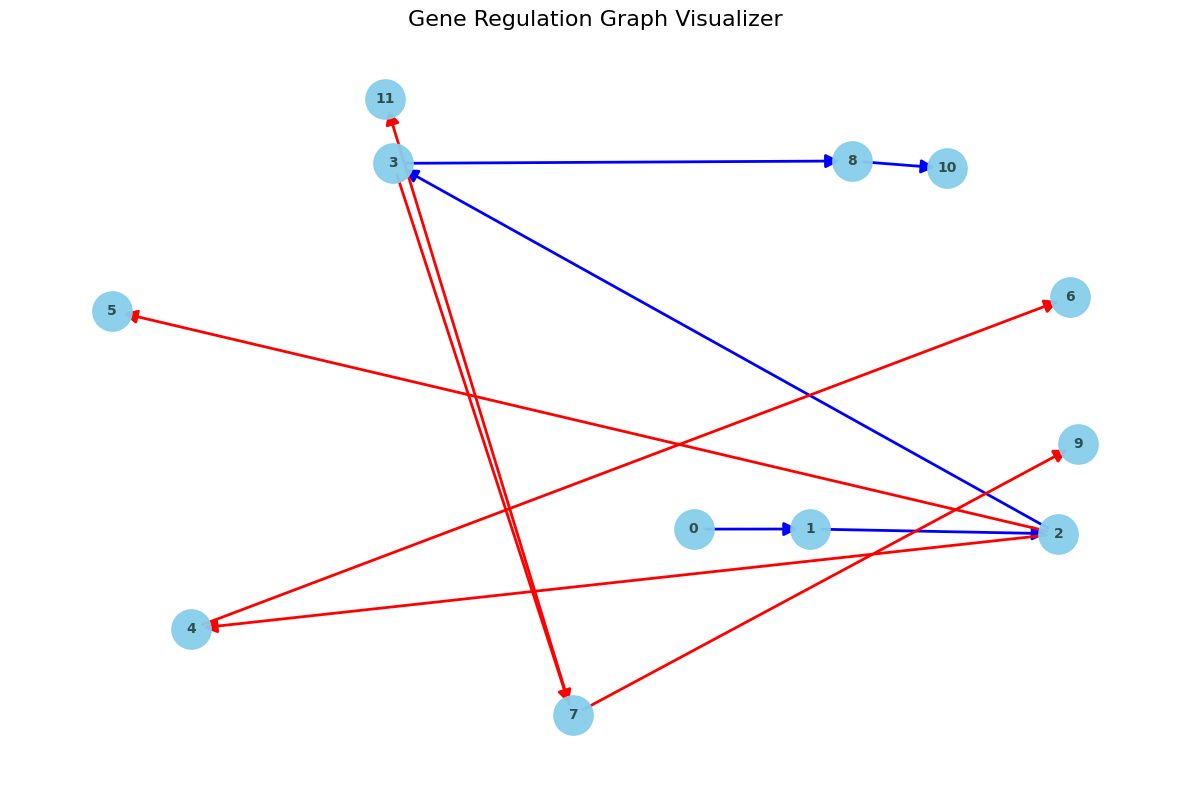

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the data as a multiline string.
# Format: target, unused, affector, regulation, unused
data = """1,1,0,3.51,2.0
2,1,1,2.44,2.0
3,1,2,2.03,2.0
4,1,2,-2.02,2.0
5,1,2,-3.75,2.0
7,1,3,-4.49,2.0
8,1,3,2.74,2.0
6,1,4,-4.88,2.0
9,1,7,-3.76,2.0
11,1,7,-2.65,2.0
10,1,8,2.12,2.0"""

# Create a directed graph
G = nx.DiGraph()

# Lists for positive and negative regulation edges
edges_pos = []
edges_neg = []

# Process the data: first col = target, third col = affector, fourth col = regulation
for line in data.strip().splitlines():
    parts = line.split(',')
    target = parts[0].strip()       # target node
    affector = parts[2].strip()     # affector node
    regulation = float(parts[3].strip())
    
    # Add nodes if not already present
    G.add_node(target)
    G.add_node(affector)
    
    # Add edge from affector to target with regulation weight.
    if regulation > 0:
        edges_pos.append((affector, target, regulation))
        G.add_edge(affector, target, weight=regulation)
    elif regulation < 0:
        edges_neg.append((affector, target, regulation))
        G.add_edge(affector, target, weight=regulation)

# Attempt to use a hierarchical layout via Graphviz (requires pygraphviz)
try:
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
except ImportError:
    # Fallback: Adjusted spring layout for improved spacing
    pos = nx.spring_layout(G, k=1.0, iterations=100)

plt.figure(figsize=(12, 8))

# Draw nodes with a refined aesthetic: larger nodes and a pleasing color.
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800, alpha=0.95)

# Draw labels with bold font.
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='darkslategray')

# Draw positive regulation edges: blue arrowheads.
nx.draw_networkx_edges(
    G, pos,
    edgelist=[(u, v) for u, v, r in edges_pos],
    edge_color='blue',
    arrowstyle='-|>',
    arrowsize=20,
    width=2
)

# Draw negative regulation edges: red arrowheads.
nx.draw_networkx_edges(
    G, pos,
    edgelist=[(u, v) for u, v, r in edges_neg],
    edge_color='red',
    arrowstyle='-|>',
    arrowsize=20,
    width=2
)

plt.title("Gene Regulation Graph Visualizer", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()
